# Avaliando o impacto de uma política pública: **Diferenças em Diferenças** (*DID/DD*)

## Programa de Subsídios a Planos de Saúde (*Health Insurance Subsidy Program - HISP*)

Objetivo primário do programa: reduzir a despesa com itens relacionados a saúde para domicílios de baixa renda.

Variável de interesse: *health_expenditures*

----

## Leitura dos Dados

In [28]:
## Já instalando bibliotecas necessárias
from IPython.display import clear_output # limpa o output de uma célula
!pip install linearmodels
!pip uninstall scipy -y
!pip install scipy

clear_output()  # limpando o texto

In [29]:
## Importando o que for necessário
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from linearmodels.iv import IV2SLS
from statsmodels.formula.api import ols
from patsy import dmatrices

In [30]:
## Montando o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
## Lendo os dados
sCaminho = "/content/drive/Othercomputers/Meu modelo MacBook Air/Documents/IPEA/Curso IDP/Avaliação de Impacto de Políticas - World Bank/Dados/"
sArquivo = "evaluation.dta"

## Lendo o DataFrame
df = pd.read_stata(f"{sCaminho}{sArquivo}")

# Vendo o tamanho da base
print(f"Linhas: {df.shape[0]}; Colunas: {df.shape[1]}")

Linhas: 19827; Colunas: 22


In [32]:
## Vendo a descrição das variáveis (só funciona com arquivos .dta)
# Lendo novamente a base, mas agora com iterator, o que retorna um objeto do tipo StataReader
stata_reader = pd.read_stata(f"{sCaminho}{sArquivo}", iterator=True)

# Pegando as descrições das variáveis
descricoes = stata_reader.variable_labels()
descricoes

{'age_hh': 'Age of the head of the household (in years)',
 'age_sp': 'Age of the spouse (in years)',
 'bathroom': 'Home with private bathroom at baseline (0=no, 1=yes)',
 'dirtfloor': 'Home has a dirt floor at baseline (0=no, 1=yes)',
 'educ_hh': 'Education of the head of household (completed years of schooling)',
 'educ_sp': 'Education of the spouse (completed years of schooling)',
 'eligible': 'Household eligible to enroll in HISP (0=no, 1=yes)',
 'enrolled': 'HH enrolled in HISP (0=no, 1=yes)',
 'enrolled_rp': 'Household enrolled in HISP under the random promotion scenario (0=no, 1=yes)',
 'female_hh': 'Head of the household is a woman (0=no, 1=yes)',
 'health_expenditures': 'Out of pocket health expenditures (per person per year)',
 'hhsize': 'Number of household members (baseline)',
 'hospital': 'HH member visited hospital in the past year (0=no, 1=yes)',
 'hospital_distance': 'Distance to closest hospital',
 'household_identifier': 'Unique household identifier',
 'indigenous': 'H

In [33]:
## Descrevendo o DataFrame
df.describe()

,locality_identifier,household_identifier,treatment_locality,promotion_locality,eligible,enrolled,enrolled_rp,poverty_index,round,health_expenditures,age_hh,age_sp,educ_hh,educ_sp,female_hh,indigenous,hhsize,dirtfloor,bathroom,land,hospital_distance,hospital
count,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,11257.000000
mean,73.933472,8038.965820,0.500277,0.512685,0.567761,0.299037,0.293287,56.789505,0.500025,17.035103,46.683117,40.581734,2.833550,2.618601,0.099057,0.352903,5.178645,0.603621,0.615978,2.079740,105.322517,0.052323
std,55.076599,4569.468262,0.500017,0.499851,0.495377,0.457822,0.455238,10.686106,0.500013,9.291589,15.294811,12.822810,2.754772,2.543370,0.298730,0.477869,2.195178,0.489157,0.486375,3.133202,42.063479,0.222696
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.479134,0.000000,0.000000,14.000000,14.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,9.465392,0.000000
25%,30.000000,3989.500000,0.000000,0.000000,0.000000,0.000000,0.000000,49.652241,0.000000,11.621977,34.000000,31.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,72.804218,0.000000
50%,59.000000,8040.000000,1.000000,1.000000,1.000000,0.000000,0.000000,56.414219,1.000000,16.051678,45.000000,41.000000,2.000000,2.000000,0.000000,0.000000,5.000000,1.000000,1.000000,1.000000,113.556497,0.000000
75%,112.000000,12033.000000,1.000000,1.000000,1.000000,1.000000,1.000000,62.905720,1.000000,21.236842,58.000000,48.000000,4.000000,4.000000,0.000000,1.000000,7.000000,1.000000,1.000000,3.000000,141.097735,0.000000
max,200.000000,15778.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000,1.000000,116.830643,88.000000,88.000000,16.000000,17.000000,1.000000,1.000000,13.000000,1.000000,1.000000,23.000000,170.457647,1.000000


In [34]:
## Criando lista e fórmula com controles
# Lista
lControles = ["age_hh", "age_sp", "educ_hh", "educ_sp", "female_hh", "indigenous",
              "hhsize", "dirtfloor", "bathroom", "land", "hospital_distance"]

# Formulas
sControles = "age_hh + age_sp + educ_hh + educ_sp + female_hh + indigenous + hhsize + dirtfloor + bathroom + land + hospital_distance"

## Diferenças em Diferenças

Suponha que não haja uma regra de seleção clara para o programa -- ou seja, não há seleção/promoção (VI) aleatória e a elegibilidade não está condicionada a um índice contínuo (RDD).

Nesses casos -- ou quando as hipóteses dos outros métodos falham --, podemos usar **Diferenças em Diferenças** ou **Pareamento** (próxima aula).

No entanto, como não conhecemos a regra de seleção, isso faz com que o método exiga pressupostos mais fortes, já que há uma dimensão a mais sobre a qual precisamos fazer suposições.

No HISP, mesmo nas localidades/vilas que receberam o tratamento, os domicílios escolhem se se inscrevem ou não no programa.

Como os domicílios que se inscrevem possuem características bem diferentes daqueles que não se inscrevem, a comparação **inscritos x não-inscritos** é viesados.

De forma semelhante, comparar **antes x depois** também será viesado, porque muitos outros fatores -- inclusive temporais e não-observáveis -- podem afetar a mudança nos gastos com saúde ao longo do tempo.

Podemos, contudo, **combinar os dois métodos**, resultando na *DiD* e produzindo uma melhor estimativa do contrafactual **local**.

*   *Primeira diferença*: **antes e depois do grupo inscrito**:
    * Isso controlará para fatores constantes no tempo nesse grupo, mas ainda temos que ligar com tudo que varia temporalmente;
*   *Segunda diferença*: **antes e depois do grupo não-inscrito**, mas que estava exposto ao mesmo conjunto de condições ambientais:
    * Controla para fatores que variam no tempo!



**IMPORTANTE**: estamos estimando o contrafactual da **mudança** nos resultados para o grupo de tratamento (ver figura 7.1, pág 146).

Ao invés de comparar os resultados entre os grupos de tratamento e de comparação após a intervenção, o método DD compara as **tendências** entre os grupos de tratamento e de comparação.

Para isso, precisamos garantir que ambos os grupos possuíam **igualdade de tendências**, o que exige a observação de pelo menos dois períodos pré-tratamento.

Como não podemos testar a igualdade de tendências pré-tratamento, teremos que supor que a mudança nos gastos com saúde do grupo não-inscrito reflita o que teria acontecido com as despesas dos inscritos na ausência do HISP.

### Médias

In [35]:
## Será que os inscritos e não-inscritos são diferentes?
# Dados dos incritos
dfInscritos = df.query('treatment_locality == 1 & enrolled == 1')

# Dados dos não incritos
dfNaoInscritos = df.query('treatment_locality == 1 & enrolled == 0')

In [36]:
## Testando as médias de cada grupo
for sVariavel in lControles:
  # Fazendo o teste
  tuplaTeste = stats.ttest_ind(dfInscritos[sVariavel], 
                               dfNaoInscritos[sVariavel], 
                               nan_policy='omit', alternative='two-sided')
  
  ## Vendo se a diferença é significante
  sAsterisco = "**" if tuplaTeste[1] < 0.05 else ""

  # Printando ([0]=estatística; [1]=p-valor)
  print(f"\n========================= {sVariavel}{sAsterisco} =========================")
  print(f"Média Tratamento: {np.around(dfInscritos[sVariavel].mean(), 2)} \t Média Comparação: {np.around(dfNaoInscritos[sVariavel].mean(), 2)}")
  print(f"Diferença = {np.around(dfInscritos[sVariavel].mean() - dfNaoInscritos[sVariavel].mean(), 2)}")
  print(f"Estatística = {np.around(tuplaTeste[0], 4)} \t P-valor = {np.around(tuplaTeste[1], 4)}")


========================= age_hh** =========================
Média Tratamento: 42.14 	 Média Comparação: 52.51
Diferença = -10.37
Estatística = -35.4769 	 P-valor = 0.0

========================= age_sp** =========================
Média Tratamento: 37.24 	 Média Comparação: 44.9
Diferença = -7.66
Estatística = -30.7568 	 P-valor = 0.0

========================= educ_hh** =========================
Média Tratamento: 2.97 	 Média Comparação: 2.71
Diferença = 0.27
Estatística = 4.6811 	 P-valor = 0.0

========================= educ_sp** =========================
Média Tratamento: 2.71 	 Média Comparação: 2.49
Diferença = 0.21
Estatística = 4.1094 	 P-valor = 0.0

========================= female_hh** =========================
Média Tratamento: 0.07 	 Média Comparação: 0.13
Diferença = -0.06
Estatística = -9.8042 	 P-valor = 0.0

========================= indigenous** =========================
Média Tratamento: 0.43 	 Média Comparação: 0.27
Diferença = 0.16
Estatística = 16.348 	 P-valor =

Os grupos são sistemicamente diferentes, de forma que comparações simples (antes x depois e inscritos x não inscritos) são viesadas.

Contudo, podemos usar a *DiD*!

In [37]:
## Média dos inscritos antes e depois (primeira diferença)
# Médias de cada período
nMediaInscritosA = dfInscritos.query('round == 0')['health_expenditures'].mean()
nMediaInscritosB = dfInscritos.query('round == 1')['health_expenditures'].mean()
nPrimeiraDiferença = nMediaInscritosB - nMediaInscritosA

# Printando
print(f"Média dos Inscritos Pré-Tratamento: US$ {round(nMediaInscritosA, 2)}")
print(f"Média dos Inscritos Pós-Tratamento: US$ {round(nMediaInscritosB, 2)}")
print(f"Primeira Diferença: US$ {round(nPrimeiraDiferença, 2)}")

Média dos Inscritos Pré-Tratamento: US$ 14.49
Média dos Inscritos Pós-Tratamento: US$ 7.84
Primeira Diferença: US$ -6.65


In [38]:
## Teste t
stats.ttest_ind(dfInscritos.query('round == 0')['health_expenditures'], 
                dfInscritos.query('round == 1')['health_expenditures'], 
                nan_policy='omit', alternative='two-sided')
# A diferença nas médias entre os inscritos pré e pós-programa é bastante significativa

Ttest_indResult(statistic=39.764560411867826, pvalue=9.90593763905028e-307)

In [39]:
## Média dos NÃO inscritos antes e depois (segunda diferença)
# Médias de cada período
nMediaNaoInscritosC = dfNaoInscritos.query('round == 0')['health_expenditures'].mean()
nMediaNaoInscritosD = dfNaoInscritos.query('round == 1')['health_expenditures'].mean()
nSegundaDiferença = nMediaNaoInscritosD - nMediaNaoInscritosC

# Printando
print(f"Média dos Não-Inscritos Pré-Tratamento: US$ {round(nMediaNaoInscritosC, 2)}")
print(f"Média dos Não-Inscritos Pós-Tratamento: US$ {round(nMediaNaoInscritosD, 2)}")
print(f"Segunda Diferença: US$ {round(nSegundaDiferença, 2)}")

Média dos Não-Inscritos Pré-Tratamento: US$ 20.79
Média dos Não-Inscritos Pós-Tratamento: US$ 22.3
Segunda Diferença: US$ 1.51


In [40]:
## Teste t
stats.ttest_ind(dfNaoInscritos.query('round == 0')['health_expenditures'], 
                dfNaoInscritos.query('round == 1')['health_expenditures'], 
                nan_policy='omit', alternative='two-sided')
# A diferença nas médias entre os não inscritos pré e pós-programa é bastante significativa,
# mas menos que a dos inscritos (veja magnitude do p-valor e da estatística)

Ttest_indResult(statistic=-4.928342458088809, pvalue=8.629919218436017e-07)

In [41]:
## Vendo a diferença em diferenças
nDID = nPrimeiraDiferença - nSegundaDiferença
print(f"Diferença em Diferenças: US$ {round(nDID, 4)}")

Diferença em Diferenças: US$ -8.1629


In [42]:
nMediaInscritosB - nMediaNaoInscritosD - (nMediaInscritosA - nMediaNaoInscritosC)

-8.162947177886963

### Modelo de Regressão DID

Y = B<sub>0</sub> + B<sub>1</sub>t + B<sub>2</sub>T + B<sub>3</sub>t*T + B<sub>4</sub>X, onde

- *t* indica se a observação é do período pré (0) ou pós-tratamento (1);
- *T* indica se a observação pertence ao grupo tratado.
- *X* é um vetor que representa as demais variáveis.

B<sub>1</sub> é um coeficiente que capta mudança temporais globais (que afetam ambos os grupos), e pode ser chamado de **efeito do tratamento nos não-tratados** (a segunda diferença acima).

B<sub>1</sub> + B<sub>3</sub> capta as mudanças temporais totais no grupo tratado, sendo chamado de **efeito do tratamento nos tratados** (primeira diferença acima). Além disso, B<sub>2</sub> controla para qualquer diferença pré-existente entre os grupos (que seja constante no tempo).

O **efeito do tratamento** é, portanto, B<sub>3</sub> (diferença em diferenças).





In [43]:
## Separando o dataset
dfLocalidadesTratadas = df.query('treatment_locality == 1')

## Modelo simples
# Formula
formula_simples_did = "health_expenditures ~ 1 + round + enrolled + round:enrolled"
formula_simples_did = "health_expenditures ~ 1 + round*enrolled"

# Modelo
modelo_simples_did = ols(formula_simples_did, data=dfLocalidadesTratadas).fit(cov_type='HC1')

# Sumário
print(modelo_simples_did.summary())

# R2 já muito bom!!

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.344
Model:                             OLS   Adj. R-squared:                  0.343
Method:                  Least Squares   F-statistic:                     1877.
Date:                 Thu, 11 Nov 2021   Prob (F-statistic):               0.00
Time:                         23:15:30   Log-Likelihood:                -34590.
No. Observations:                 9919   AIC:                         6.919e+04
Df Residuals:                     9915   BIC:                         6.922e+04
Df Model:                            3                                         
Covariance Type:                   HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         20.7915      0.1

In [44]:
## Mesmo resultado da análise com médias e subtrações! E se adicionarmos outras variáveis?

# Formula
formula_completa_did = f"{formula_simples_did} + {sControles}"

# Modelo
modelo_completo_did = ols(formula_completa_did, data=dfLocalidadesTratadas).fit(
    use_t=True,
    cov_type='cluster',
    cov_kwds={'groups':dfLocalidadesTratadas['locality_identifier']}
)

# Sumário
print(modelo_completo_did.summary())

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.552
Model:                             OLS   Adj. R-squared:                  0.551
Method:                  Least Squares   F-statistic:                     2410.
Date:                 Thu, 11 Nov 2021   Prob (F-statistic):          1.13e-118
Time:                         23:18:01   Log-Likelihood:                -32700.
No. Observations:                 9919   AIC:                         6.543e+04
Df Residuals:                     9904   BIC:                         6.554e+04
Df Model:                           14                                         
Covariance Type:               cluster                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            27.3946

### Análise Gráfica

In [45]:
## Criando um DataFrame com os valores
dfMedias = pd.DataFrame([[nMediaInscritosA, nMediaNaoInscritosC], 
                         [nMediaInscritosB, nMediaNaoInscritosD]],
                        columns=["Inscritos", "Não-Inscritos"],
                        index=["Pré", "Pós"])
dfMedias

,Inscritos,Não-Inscritos
Pré,14.489692,20.791475
Pós,7.840174,22.304905


In [46]:
## Simulando contrafactual dos inscritos ASSUMINDO IGUALDADE DE TENDÊNCIAS
# Pegando variação nos valores dos Não-Inscritos
nVariacaoNaoInscritos = nMediaNaoInscritosD - nMediaNaoInscritosC
nVariacaoNaoInscritos

1.5134296417236328

In [47]:
# Criando coluna e vendo resultado
dfMedias["Contrafactual (IT)"] = np.where(
    dfMedias.index == "Pré",
    nMediaInscritosA,
    nMediaInscritosA + nVariacaoNaoInscritos
)

dfMedias

,Inscritos,Não-Inscritos,Contrafactual (IT)
Pré,14.489692,20.791475,14.489692
Pós,7.840174,22.304905,16.003121


Text(1, 16.503121376037598, 'E')

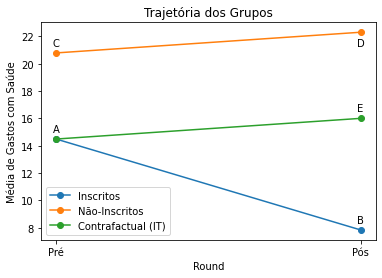

In [49]:
## Plottando
# Plot Inicial
dfMedias.plot(marker='o')

# Títulos
plt.title("Trajetória dos Grupos")
plt.xlabel("Round")
plt.ylabel("Média de Gastos com Saúde")
# Legendas do eixo x
plt.xticks(ticks=[0, 1], labels=["Pré", "Pós"])
# Anotações
plt.annotate("A", xy=(0, nMediaInscritosA + 0.5), ha="center")
plt.annotate("B", xy=(1, nMediaInscritosB + 0.5), ha="center")
plt.annotate("C", xy=(0, nMediaNaoInscritosC + 0.5), ha="center")
plt.annotate("D", xy=(1, nMediaNaoInscritosD - 1), ha="center")
plt.annotate("E", xy=(1, nMediaInscritosA + nVariacaoNaoInscritos + 0.5), ha="center")

### Teste Placebo

Text(58.5, 0.6, 'Linha de pobreza: 58')

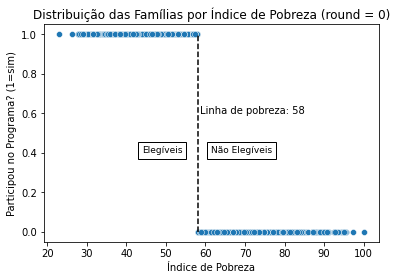

In [75]:
## Criando grupo de tratamento placebo
# Restringindo o dataset à quem NÃO foi tratado - como vimos na última aula, todas as pessoas
# com poverty_index <= 58 participaram do programa (cumprimento total)

# Linha de pobreza
nPobreza = 58

# Objeto gráfico
fig = plt.Figure(figsize=(10,10), dpi=200, tight_layout=True)
# Pontos
gPontos = sns.scatterplot(data=dfLocalidadesTratadas.query('round == 0'),
                          x='poverty_index',
                          y='enrolled')
# Linha vertical pontilhada
plt.vlines(x=nPobreza, ymin=0, ymax=1, linestyles='dashed')
# Título
plt.title("Distribuição das Famílias por Índice de Pobreza (round = 0)")
plt.xlabel("Índice de Pobreza")
plt.ylabel("Participou no Programa? (1=sim)")
# Anotações
plt.annotate("Elegíveis", xy=(49, 0.4), bbox=dict(facecolor='none', edgecolor='black'), ha='center', fontsize=9)
plt.annotate("Não Elegíveis", xy=(69, 0.4), bbox=dict(facecolor='none', edgecolor='black'), ha='center', fontsize=9)
plt.annotate(f"Linha de pobreza: {nPobreza}", xy=(58.5, 0.6), fontsize=10)

In [76]:
## Retirando observações com pobreza <= 58
dfPlacebo = dfLocalidadesTratadas.query('poverty_index > 58')

In [87]:
## Nosso grupo placebo será aquele próximo aos tratados
# Definindo raio
nRaio = 5

# Criando dummy
dfPlacebo['placebo'] = np.where(
    dfPlacebo['poverty_index'] <= nPobreza + nRaio,
    1,
    0
)

## Vendo resultado
dfPlacebo[['poverty_index', 'placebo']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,poverty_index,placebo
11258,73.840805,0
11257,73.840805,0
11259,60.973724,1
11260,60.973724,1
11262,58.500774,1
...,...,...
19777,66.846985,0
19823,62.055641,1
19824,62.055641,1
19825,62.828438,1


In [88]:
## Vendo número de placebos
dfPlacebo.groupby('placebo')['placebo'].count()

placebo
0    2174
1    1816
Name: placebo, dtype: int64

In [89]:
## Média dos placebos antes e depois (primeira diferença)
# Médias de cada período
nMediaPlaceboA = dfPlacebo.query('placebo == 1 & round == 0')['health_expenditures'].mean()
nMediaPlaceboB = dfPlacebo.query('placebo == 1 & round == 1')['health_expenditures'].mean()
nPrimeiraDiferença = nMediaPlaceboB - nMediaPlaceboA

# Printando
print(f"Média dos Inscritos Pré-Tratamento: US$ {round(nMediaPlaceboA, 2)}")
print(f"Média dos Inscritos Pós-Tratamento: US$ {round(nMediaPlaceboB, 2)}")
print(f"Primeira Diferença: US$ {round(nPrimeiraDiferença, 2)}")

Média dos Inscritos Pré-Tratamento: US$ 19.8
Média dos Inscritos Pós-Tratamento: US$ 21.0
Primeira Diferença: US$ 1.2


In [90]:
## Teste t
stats.ttest_ind(dfPlacebo.query('placebo == 1 & round == 0')['health_expenditures'], 
                dfPlacebo.query('placebo == 1 & round == 1')['health_expenditures'], 
                nan_policy='omit', alternative='two-sided')

Ttest_indResult(statistic=-2.846644086559846, pvalue=0.004467971882260217)

In [91]:
## Média dos controles antes e depois (segunda diferença)
# Médias de cada período
nMediaControleC = dfPlacebo.query('placebo == 0 & round == 0')['health_expenditures'].mean()
nMediaControleD = dfPlacebo.query('placebo == 0 & round == 1')['health_expenditures'].mean()
nSegundaDiferença = nMediaControleD - nMediaControleC

# Printando
print(f"Média dos Inscritos Pré-Tratamento: US$ {round(nMediaControleC, 2)}")
print(f"Média dos Inscritos Pós-Tratamento: US$ {round(nMediaControleD, 2)}")
print(f"Segunda Diferença: US$ {round(nSegundaDiferença, 2)}")

Média dos Inscritos Pré-Tratamento: US$ 21.62
Média dos Inscritos Pós-Tratamento: US$ 23.4
Segunda Diferença: US$ 1.78


In [92]:
stats.ttest_ind(dfPlacebo.query('placebo == 0 & round == 0')['health_expenditures'], 
                dfPlacebo.query('placebo == 0 & round == 1')['health_expenditures'], 
                nan_policy='omit', alternative='two-sided')

Ttest_indResult(statistic=-4.072388706641866, pvalue=4.8201727829014256e-05)

In [93]:
## Diferença em Diferenças
# Idealmente, se houvesse igualdade de tendências, esse valor seria (próximo de) 0
nDIDPlacebo = (nMediaPlaceboB - nMediaControleD) - (nMediaPlaceboA - nMediaControleC)
print(f"Diferença em Diferenças: US$ {round(nDIDPlacebo, 4)}")

Diferença em Diferenças: US$ -0.5764


In [94]:
#### Vendo se a diferença em diferenças é significativamente diferente de 0
## Ordenando o DataFrame
dfPlacebo.sort_values(by=['household_identifier', 'round'], inplace=True)

## Criando coluna no dataframe com as diferenças
dfPlacebo["diferenca_gastos"] = dfPlacebo['health_expenditures'].diff()

## Vendo o resultado
clear_output()
dfPlacebo[["household_identifier", "round", "diferenca_gastos", "health_expenditures"]]

,household_identifier,round,diferenca_gastos,health_expenditures
11258,2.0,0.0,NaN,21.700567
11257,2.0,1.0,5.522541,27.223108
11259,3.0,0.0,-2.850145,24.372963
11260,3.0,1.0,-3.462915,20.910048
11262,14.0,0.0,1.338516,22.248564
...,...,...,...,...
19777,15681.0,1.0,-0.886236,21.585629
19823,15769.0,0.0,-5.679626,15.906003
19824,15769.0,1.0,-7.657851,8.248152
19825,15778.0,0.0,0.489620,8.737772


In [95]:
## Deixando apenas valores do round 1
dfPlacebo['diferenca_gastos'] = np.where(
    dfPlacebo['round'] == 0,
    np.nan,
    dfPlacebo['diferenca_gastos']
)

dfPlacebo[["household_identifier", "round", "diferenca_gastos", "health_expenditures"]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,household_identifier,round,diferenca_gastos,health_expenditures
11258,2.0,0.0,NaN,21.700567
11257,2.0,1.0,5.522541,27.223108
11259,3.0,0.0,NaN,24.372963
11260,3.0,1.0,-3.462915,20.910048
11262,14.0,0.0,NaN,22.248564
...,...,...,...,...
19777,15681.0,1.0,-0.886236,21.585629
19823,15769.0,0.0,NaN,15.906003
19824,15769.0,1.0,-7.657851,8.248152
19825,15778.0,0.0,NaN,8.737772


In [96]:
# Teste t
stats.ttest_ind(dfPlacebo.query('placebo == 0')['diferenca_gastos'], 
                dfPlacebo.query('placebo == 1')['diferenca_gastos'], 
                nan_policy='omit', alternative='two-sided')

# Não podemos rejeitar a hipótese de DiD = 0! (com raio 5)
## Com raio 1, a diferença é muito marginalmente significante

Ttest_indResult(statistic=1.1227031559698104, pvalue=0.26169881660272526)

# Obrigado!